<a href="https://colab.research.google.com/github/KubaWinsztal/MachineLearning/blob/main/PD4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

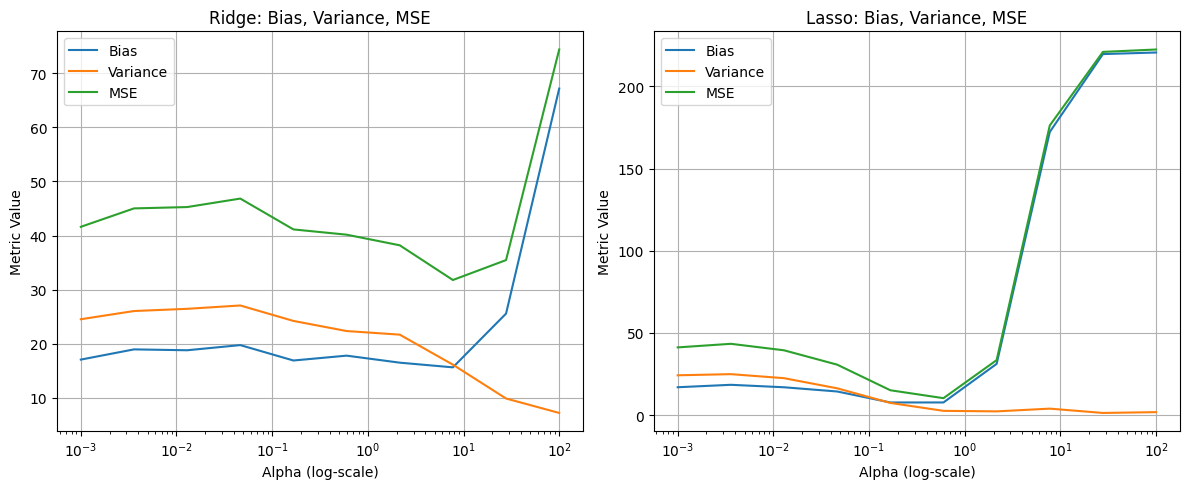

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import train_test_split

# 1. Generate Synthetic Data
np.random.seed(42)
n_samples = 200
n_features = 50

# True coefficients: only a few non-zero
true_coefs = np.zeros(n_features)
true_coefs[:5] = [10, -8, 6, 4, -2]  # 5 non-zero features

X = np.random.randn(n_samples, n_features)
y_true = X @ true_coefs
# Add noise
noise = np.random.normal(0, 5, size=n_samples)
y = y_true + noise

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
y_test_true = X_test @ true_coefs  # True (noise-free) targets for bias calculation

# 2. Define Functions to Compute Bias, Variance, MSE
def compute_bias_variance_mse(predictions, y_true):
    """
    predictions: shape (n_runs, n_samples_test)
    y_true: shape (n_samples_test,)
    Returns: (bias, variance, mse)
    """
    # Mean prediction across runs
    mean_pred = np.mean(predictions, axis=0)

    # Bias^2: average squared difference between mean prediction and true target
    bias = np.mean((mean_pred - y_true)**2)

    # Variance: average variance of predictions around their mean
    var = np.mean(np.var(predictions, axis=0))

    # MSE: average over all runs of the squared error
    mse = np.mean((predictions - y_true[None, :])**2)

    return bias, var, mse

# 3. Vary Regularization Parameter, Collect Metrics
alphas = np.logspace(-3, 2, 10)  # Range of lambda (alpha) values
n_runs = 50  # Number of repeated fits to estimate variance

ridge_biases, ridge_vars, ridge_mses = [], [], []
lasso_biases, lasso_vars, lasso_mses = [], [], []

for alpha in alphas:
    # Collect predictions across multiple runs
    ridge_preds = []
    lasso_preds = []

    for _ in range(n_runs):
        # Resample training set (optional step to see variability)
        idx = np.random.choice(range(len(X_train)), size=len(X_train), replace=True)
        X_boot, y_boot = X_train[idx], y_train[idx]

        # Ridge
        ridge = Ridge(alpha=alpha, fit_intercept=True)
        ridge.fit(X_boot, y_boot)
        ridge_preds.append(ridge.predict(X_test))

        # Lasso
        lasso = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)
        lasso.fit(X_boot, y_boot)
        lasso_preds.append(lasso.predict(X_test))

    # Convert to arrays for bias-variance calculations
    ridge_preds = np.array(ridge_preds)
    lasso_preds = np.array(lasso_preds)

    # Compute metrics using noise-free y_test_true to evaluate bias
    b_ridge, v_ridge, mse_ridge = compute_bias_variance_mse(ridge_preds, y_test_true)
    b_lasso, v_lasso, mse_lasso = compute_bias_variance_mse(lasso_preds, y_test_true)

    ridge_biases.append(b_ridge)
    ridge_vars.append(v_ridge)
    ridge_mses.append(mse_ridge)

    lasso_biases.append(b_lasso)
    lasso_vars.append(v_lasso)
    lasso_mses.append(mse_lasso)

# 4. Plot Results
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Ridge: Bias, Variance, MSE")
plt.plot(alphas, ridge_biases, label="Bias")
plt.plot(alphas, ridge_vars, label="Variance")
plt.plot(alphas, ridge_mses, label="MSE")
plt.xscale('log')
plt.xlabel("Alpha (log-scale)")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title("Lasso: Bias, Variance, MSE")
plt.plot(alphas, lasso_biases, label="Bias")
plt.plot(alphas, lasso_vars, label="Variance")
plt.plot(alphas, lasso_mses, label="MSE")
plt.xscale('log')
plt.xlabel("Alpha (log-scale)")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

**PYTANIE 1**


W miarę zwiększania wartości parametru λ w obu modelach, Ridge i Lasso, obserwujemy wzrost bias, co oznacza, że modele stają się bardziej uproszczone i mniej elastyczne w dopasowaniu do danych treningowych. Przy małych wartościach λ oba modele wykazują niski bias, ale wysoką wariancję, co oznacza, że są podatne na nadmierne dopasowanie do szumu w danych. Istotną różnicą jest jednak to, że Lasso dodatkowo wprowadza selekcję cech — dla większych wartości λ wyzerowuje nieistotne współczynniki, podczas gdy Ridge jedynie je pomniejsza, zachowując wszystkie predyktory w modelu. Zauważalne jest również, że dla tych samych wartości λ, Lasso szybciej upraszcza model, prowadząc do szybszego wzrostu biasu i redukcji wariancji w porównaniu do Ridge. W obu przypadkach wykres MSE przyjmuje kształt rozciągniętej litery "U" — wskazuje to na istnienie optymalnej wartości λ, przy której kompromis między biasem a wariancją jest najkorzystniejszy, jednak u Lasso punkt ten często pojawia się przy nieco mniejszej wartości λ ze względu na silniejszą penalizację nieistotnych zmiennych.


**PYTANIE 2**

### Dekompozycja MSE: Kompromis Bias-Variance

Średni błąd kwadratowy (MSE) można rozłożyć na trzy składowe:

\begin{equation}
\mathrm{MSE} = \mathrm{Bias}^2 + \mathrm{Wariancja} + \mathrm{Szum}
\end{equation}

**Wyjaśnienie składników**:
1. **Bias²** (kwadrat obciążenia):  
   - Mierzy systematyczny błąd modelu (np. gdy model jest zbyt prosty, by uchwycić zależności w danych).  

2. **Wariancja**:  
   - Określa, jak bardzo przewidywania modelu zmieniają się w odpowiedzi na fluktuacje w danych treningowych.  
   - Wysoka wariancja = przeuczenie (model "uczy się" szumu).

3. **Szum** (wariancja błędu losowego):  
   - Nieusuwalny składnik związany z losowością w danych (np. błędy pomiarowe).  
   - Nie zależy od modelu – zawsze wpływa na MSE.

**Interpretacja**:  
- **Cel modelowania**: Znaleźć balans między biasem a wariancją, aby **zminimalizować MSE**.  
- **Regularyzacja** (np. Ridge/Lasso) pozwala kontrolować ten kompromis poprzez parametr λ.

**PYTANIE 3**

Tak, regularyzacja prowadzi do istnienia optymalnego punktu, w którym błąd średniokwadratowy (MSE) jest minimalny, a wynika to z równoważenia biasu i wariancji. Przy niskich wartościach λ model jest bardzo elastyczny, potrafi szczegółowo odwzorować dane treningowe, co skutkuje niskim biasem, ale jednocześnie wysoką wariancją — predykcje są niestabilne i mocno zależą od szumu w danych. Z kolei przy wysokim λ model staje się zbyt uproszczony, przez co rośnie bias, ponieważ nie jest w stanie dostatecznie dobrze odwzorować nawet istotnych zależności, choć wariancja maleje. Zarówno zbyt małe, jak i zbyt duże λ prowadzi do zwiększenia MSE — raz z powodu zbyt dużej wariancji (overfitting), a raz z powodu zbyt dużego biasu (underfitting). Optymalna wartość λ znajduje się pomiędzy tymi skrajnymi przypadkami, w punkcie, gdzie bias i wariancja są najlepiej zrównoważone, a MSE osiąga minimum. To właśnie ten kompromis jest kluczowym celem regularyzacji — ograniczyć wariancję bez nadmiernego wzrostu biasu.

**PYTANIE 4**

Ridge i Lasso to metody regularyzacji, które różnią się sposobem kontroli złożoności modelu i podejściem do kompromisu między biasem a wariancją. Obie techniki ograniczają złożoność modelu i zmniejszają wariancję prognoz, ale robią to w odmienny sposób.

Ridge regression (regularyzacja L2) dodaje karę w postaci sumy kwadratów współczynników, co skutkuje ich zmniejszeniem, ale nigdy nie sprowadza ich dokładnie do zera. Oznacza to, że wszystkie zmienne pozostają w modelu, choć z ograniczonym wpływem. Ridge wprowadza umiarkowane zwiększenie biasu, ale efektywnie redukuje wariancję, co jest szczególnie korzystne w sytuacjach, gdy zmienne objaśniające są silnie skorelowane. Zamiast eliminować losowo niektóre cechy, Ridge „dzieli” ich wpływ, zapewniając stabilniejsze i bardziej przewidywalne wyniki.

Lasso regression (regularyzacja L1) stosuje karę opartą na sumie modułów współczynników, co nie tylko ogranicza ich wartości, ale potrafi też sprowadzać je do zera. Tym samym Lasso automatycznie wykonuje selekcję zmiennych, eliminując te, które nie wnoszą istotnych informacji do modelu. To prowadzi do znacznej redukcji wariancji i uproszczenia modelu, ale kosztem wzrostu biasu — istnieje ryzyko pominięcia istotnych relacji. Lasso najlepiej sprawdza się, gdy rzeczywisty model jest rzadki (sparse), tzn. zawiera tylko kilka istotnych predyktorów. Wadą Lasso może być jego zachowanie w przypadku silnie skorelowanych zmiennych — model często wybiera jedną zmienną z grupy i odrzuca pozostałe, co nie zawsze jest optymalne.

**PYTANIE 5**

Wybór pomiędzy metodą Ridge a Lasso w dużej mierze zależy od charakterystyki danych, a w szczególności od liczby istotnych zmiennych oraz relacji zachodzących między predyktorami. Lasso znajduje zastosowanie przede wszystkim w sytuacjach, gdy model jest rzadki (sparse), czyli tylko niewielka część zmiennych rzeczywiście wpływa na zmienną objaśnianą, a pozostałe stanowią jedynie szum informacyjny. Dzięki mechanizmowi regularyzacji L1, Lasso nie tylko ogranicza wartości współczynników, ale potrafi je całkowicie sprowadzić do zera, efektywnie przeprowadzając automatyczną selekcję zmiennych. Skutkiem tego jest uzyskanie modelu bardziej zwięzłego, prostszego w interpretacji i często lepiej generalizującego w warunkach, gdy liczba zmiennych znaczących jest ograniczona. Co ważne, Lasso minimalizuje ryzyko przeuczenia w przypadku dużej liczby nieistotnych predyktorów.

Z kolei Ridge jest metodą szczególnie korzystną w analizie danych, w których występuje silna współliniowość między predyktorami, czyli korelacje pomiędzy zmiennymi objaśniającymi są wysokie. W takich przypadkach klasyczne regresje liniowe lub Lasso mogą prowadzić do niestabilnych oszacowań współczynników lub do przypadkowego (i zarazem niechcianego) wyeliminowania jednej z silnie skorelowanych cech. Ridge, poprzez regularyzację L2, nie odrzuca zmiennych, lecz równomiernie tłumi ich współczynniki, rozkładając ich wagę w sposób zrównoważony. Dzięki temu uzyskujemy model bardziej stabilny, mniej wrażliwy na drobne zmiany w danych i lepiej radzący sobie z problemem wielokolinearności. Dodatkowo, Ridge okazuje się korzystny również wtedy, gdy większość predyktorów ma umiarkowany, ale rzeczywisty wpływ na zmienną zależną — w takich sytuacjach Lasso mogłoby zbyt agresywnie redukować liczbę zmiennych, pomijając istotne informacje.